# Import Modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import re
import matplotlib.patches as patches
!pip install ultralytics -qq
from ultralytics import YOLO
import os
import yaml
import shutil
from tqdm import tqdm
from ultralytics import YOLO
import glob
import json

# Read Files

In [2]:
train = pd.read_csv("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Train.csv")
test = pd.read_csv("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Test.csv")

# Data Cleaning

In [3]:
train.dropna(inplace=True)

# Split the data

We won't be splitting the data using the train_test_split because we will lose information of some bounding boxes. Instead we are going to split the dataset depending on the image_ids

In [4]:
unique_images = train['image_id'].unique()
len(unique_images)

2465

In [5]:
val_size = int(len(unique_images) * 0.3)
val_size

739

In [6]:
train_imgs = unique_images[:(len(unique_images) - val_size)]
val_imgs = unique_images[-val_size:]

train_imgs.shape, val_imgs.shape

((1726,), (739,))

In [7]:
train_idx = np.isin(train['image_id'].values, train_imgs)
val_idx = np.isin(train['image_id'].values, val_imgs)

train_idx.shape, val_idx.shape

((23849,), (23849,))

In [8]:
train_df = train.iloc[train_idx]
val_df = train.iloc[val_idx]

# Visualize

In [9]:
sample_img = "id_5d1r9l1jp7b5"

In [10]:
image_df = train_df[train_df['image_id'] == sample_img]

In [11]:
#The bbox column is a string, so we are going to decode the data points using regex
def decode_points(ddbox: str) -> list:
    points = [np.float32(point) for point in re.findall(r'\d+\.\d+', ddbox)]
    return points

In [12]:
#test and see
decode_points("[409.0, 444.0, 44.0, 54.0]")

[409.0, 444.0, 44.0, 54.0]

In [13]:
def plot_image_with_bbox(image_path, bboxes):
    img = Image.open(image_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img)

    for bbox in bboxes:
        x, y, w, h = decode_points(bbox)
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()


In [14]:
img_path = f"/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/{sample_img}.tif"

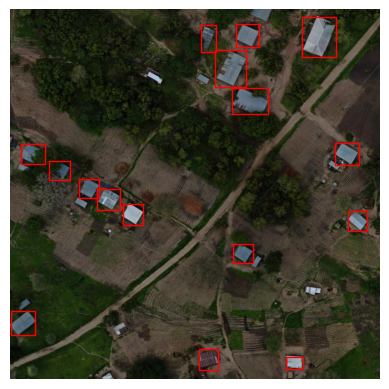

In [15]:
plot_image_with_bbox(img_path, image_df['bbox'].values)

# Split the data in YOLO format 

To fine-tune YOLO using ultralytics, the data has to follow the following hierachy

- train
    - images
    - labels
    
- val
    - images
    - labels
    
- test
    - images
    - labels
    
Since we have no test data with labels, going to consider only the train and the val folders

In [16]:
#check for null values
for col in train_df:
    print(col, train_df[col].isnull().sum())

image_id 0
bbox 0
category_id 0
id 0


In [17]:
for col in val_df:
    print(col, val_df[col].isnull().sum())

image_id 0
bbox 0
category_id 0
id 0


In [18]:
copy_from_folder = "/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images"

In [19]:
#copy the images to their respective data folders
def create_data_folder(destination_folder, df):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    unique_images = df['image_id'].unique()
    
    for img in unique_images:
        img_path = os.path.join(copy_from_folder, img + '.tif')
        shutil.copy(img_path, destination_folder)

In [20]:
train_destination_folder = "/kaggle/working/train/images"
val_destination_folder = "/kaggle/working/val/images"

In [21]:
create_data_folder(train_destination_folder, train_df)
create_data_folder(val_destination_folder, val_df)


In [22]:
img = Image.open("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/id_00qr9gisgz51.tif")
img.width, img.height

(500, 500)

In [23]:
img_width = 500
img_height = 500

**Create the label files for the images**

In [24]:
#scale the dataset to the YOLO format
def convert_bbox_to_string(bbox):
    box = decode_points(bbox)
    w = box[2]
    h = box[3]
    xc = box[0] + int(np.round(w/2))
    yc = box[1] + int(np.round(h/2))
    box = [xc/img_width, yc/img_height, w/img_width, h/img_height]
    box = [f"{i:.4g}" for i in box]
    return " ".join(box)

In [25]:
def create_label_folder(label_dir, dataframe):
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        
    unique_images = dataframe['image_id'].unique()
    
    for i,img in zip(tqdm(range(len(unique_images))), unique_images):
        df = dataframe[dataframe['image_id'] == img]
        output_lines = []
        for index, row in df.iterrows():
            category_id = int(row['category_id']) - 1

            bbox_string = convert_bbox_to_string(row['bbox'])
            output_lines.append(f'{category_id} {bbox_string}')

        with open(f"{label_dir}/{img}.txt", 'w') as f:
            for line in output_lines:
                f.write(line + '\n')

In [26]:
create_label_folder("/kaggle/working/train/labels", train_df)
create_label_folder("/kaggle/working/val/labels", val_df)

100%|██████████| 739/739 [00:00<00:00, 813.27it/s]


In [27]:
num_classes = 3
names = ["Other","Tin","Thatch"]

In [28]:
train_dest_dir = "/kaggle/working/train"
val_dest_dir = "/kaggle/working/val"

# Finally create the data.yaml file

In [29]:
dict_file = {
    'train': train_dest_dir,
    'val' : val_dest_dir,
    'nc': num_classes,
    'names': names
    }

with open("/kaggle/working/data.yaml", 'w+') as file:
    yaml.dump(dict_file, file)

In [30]:
### read yaml file created
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

yaml_data = read_yaml_file("/kaggle/working/data.yaml")

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Other
- Tin
- Thatch
nc: 3
train: /kaggle/working/train
val: /kaggle/working/val



# Train

In [31]:
#configure weights and biases
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
# model = YOLO('yolov8n.pt')


In [4]:
from ray import tune
model = YOLO('yolov8n.pt')
result = model.tune(data="/kaggle/working/data.yaml", space={"epochs": tune.choice([50,60,70]),
                                                            "batch size": tune.choice([8,16,32]),
                                                            "imgsz":tune.choice([640,1280]),
                                                            "optimizer":tune.choice(['Adam','SGD','Adamax'])},use_ray=True)

2024-06-23 14:38:06,358	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-23 14:38:07,268	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


NameError: name 'YOLO' is not defined

In [ ]:
# print(result)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
OPTIMIZER = "auto"
SEED = 42
NAME = f"Arm_Yolo_{EPOCHS}"
DEVICE = [0]
VERBOSE = False
RESUME = False
PATIENCE = 20

In [ ]:
%%time
### train
model.train(
    data = "/kaggle/working/data.yaml",
    task = 'detect',
    imgsz = (img_height, img_width),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    optimizer = OPTIMIZER,
    patience = PATIENCE,
    name = NAME,
    seed = SEED,
    val = True,
    resume = RESUME,
    device = DEVICE,
    verbose = VERBOSE
)

In [179]:
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_height, img_width),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.39 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
WARNING ⚠️ imgsz=[500, 500] must be multiple of max stride 32, updating to [512, 512]
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/Arm_Yolo_107/weights/best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 7, 5376) (5.9 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 0.8s, saved as 'runs/detect/Arm_Yolo_107/weights/best.onnx' (11.6 MB)

Export complete (1.0s)
Results saved to /kaggle/working/runs/detect/Arm_Yolo_107/weights
Predict:         yolo predict task=detect model=runs/detect/Arm_Yolo_107/weights/best.onnx imgsz=512  
Validate:        yolo val task=detect model=runs/detect/Arm_Yolo_107/weights/best.onnx imgsz=512 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'runs/detect/Arm_Yolo_107/weights/best.onnx'

In [180]:
results_paths = [
    i for i in
    glob.glob(f'/kaggle/working/runs/detect/{NAME}/*.png') +
    glob.glob(f'/kaggle/working/runs/detect/{NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/Arm_Yolo_10/confusion_matrix.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/F1_curve.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/PR_curve.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/P_curve.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/R_curve.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/results.png',
 '/kaggle/working/runs/detect/Arm_Yolo_10/labels_correlogram.jpg',
 '/kaggle/working/runs/detect/Arm_Yolo_10/labels.jpg']

In [181]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

/kaggle/working/runs/detect/Arm_Yolo_10/F1_curve.png


/kaggle/working/runs/detect/Arm_Yolo_10/PR_curve.png


/kaggle/working/runs/detect/Arm_Yolo_10/P_curve.png


/kaggle/working/runs/detect/Arm_Yolo_10/R_curve.png


/kaggle/working/runs/detect/Arm_Yolo_10/confusion_matrix.png


/kaggle/working/runs/detect/Arm_Yolo_10/confusion_matrix_normalized.png


/kaggle/working/runs/detect/Arm_Yolo_10/labels.jpg


/kaggle/working/runs/detect/Arm_Yolo_10/labels_correlogram.jpg


/kaggle/working/runs/detect/Arm_Yolo_10/results.png




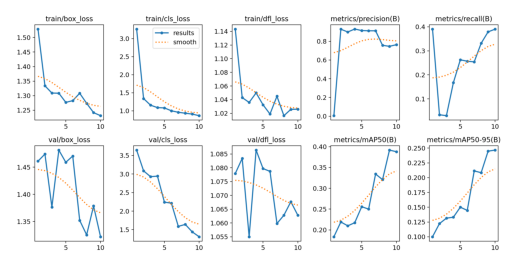

In [182]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [183]:
pred = model.predict("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/id_04ywt8kphcdv.tif")

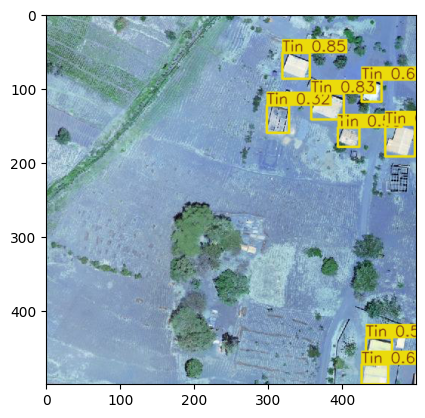

In [184]:
plt.imshow(pred[0].plot())

In [185]:
pred_json = pred[0].tojson()
pred_json

'[\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.88763,\n    "box": {\n      "x1": 458.16904,\n      "y1": 149.88516,\n      "x2": 498.29434,\n      "y2": 192.18362\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.84737,\n    "box": {\n      "x1": 319.44299,\n      "y1": 52.49208,\n      "x2": 356.50385,\n      "y2": 87.25371\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.83275,\n    "box": {\n      "x1": 358.36392,\n      "y1": 107.15218,\n      "x2": 402.13586,\n      "y2": 142.99158\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.66458,\n    "box": {\n      "x1": 426.49005,\n      "y1": 473.44711,\n      "x2": 462.83899,\n      "y2": 500.0\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.64543,\n    "box": {\n      "x1": 426.89099,\n      "y1": 89.55398,\n      "x2": 453.47931,\n      "y2": 118.6824\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n  

# Test Inference

In [186]:
def get_classes_count(pred_json: str):
    classes_count = {}
    classes_count[0] = 0
    classes_count[1] = 0
    classes_count[2] = 0
    for j in json.loads(pred_json):
        classes_count[j['class']] += 1
        
    return classes_count

In [187]:
get_classes_count(pred_json)

{0: 0, 1: 8, 2: 0}

In [188]:
# test.head()

In [189]:
sample_submission = pd.read_csv("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/SampleSubmission.csv")
sample_submission.head()

,image_id,Target
0,id_uawi0k5spci5_1,0
1,id_uawi0k5spci5_2,0
2,id_uawi0k5spci5_3,0
3,id_ba566jv4xzln_1,0
4,id_ba566jv4xzln_2,0


In [190]:
submission_df = pd.DataFrame(columns=["image_id", "Target"])

In [191]:
for index, row in tqdm(test.iterrows(), total=len(test)):
    pred = model.predict(f"/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/{row['image_id']}.tif")
    pred_json = get_classes_count(pred[0].tojson())
    
    df = pd.DataFrame({"image_id" : [f"{row['image_id']}_1",
                                     f"{row['image_id']}_2",
                                     f"{row['image_id']}_3"],
                      "Target" : [pred_json[0], pred_json[1], pred_json[2]]},columns=["image_id", "Target"])
    submission_df = pd.concat([submission_df, df], axis = 0)


100%|██████████| 2045/2045 [01:03<00:00, 32.25it/s]


In [193]:
submission_df.to_csv("score011.csv", index=False)

# Final Tips

Below are possible tips and ideas that could help get better results
- Carryout Exploratory data analysis, clean the data as some of the images are corrupt
- Data Augmentation can also definetely helpout
- Hyper-parameter Tuning is also an approach assured to yield better results. 

Anyways thanks for Viewing, Kindly provide an upvote if this was helpful. Enjoy the competition 🚀